<a href="https://colab.research.google.com/github/alouwyck/PhD/blob/main/chapter12_linear_programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

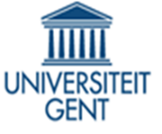<br>

**Axisymmetric Flow in Multilayer Aquifer Systems:**<br> 
**Solutions and Theorical Considerations**<br><br>
Andy Louwyck (2023)

---



---

# **CHAPTER 12: Using Linear Programming to Revisit the Optimization of a Combined Pumping and Deep Infiltration System at the Excavation Site ‘Duinenabdij’**

This Jupyter notebook implements the optimization of the drainage system discussed in chapter 12 of my PhD thesis.

## Import statements

Import the required packages, modules, and functions.

In [1]:
import numpy as np
from numpy.linalg import multi_dot as mdot
import warnings
import scipy as sp
from scipy.linalg import eig, inv, solve, LinAlgWarning
from scipy.special import i0, k0
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

In [2]:
# check versions

#print("NumPy ", np.__version__)
#print("Matplotlib", matplotlib.__version__)
#print("SciPy", sp.__version__)

NumPy  1.22.4
Matplotlib 3.7.1
SciPy 1.10.1


[PuLP](https://coin-or.github.io/pulp/) is also needed.

In [ ]:
!pip install pulp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 8.6 MB/s eta 0:00:00


In [ ]:
from pulp import *

## Axisymmetric steady multilayer well-flow

Define class to simulate axisymmetric steady state flow to a well in a multilayer aquifer system.

In [ ]:
class MultiLayerSteadyWellFlow:
    '''
    class to build models for axisymmetric multilayer well-flow
    '''
    
    def __init__(self, R, T, c, Q):
        '''
        R is distance [L] of outer model boundary (float)
        T is vector with layer transmissivities [L²/T] (array-like)
        c is vector with resistances [T] (array-like)
        Q is vector with pumping rates [L³/T] (array-like)
        if there are nl layers, then len(T) == len(Q) == nl and len(c) == nl + 1
        '''
        self.R = float(R) 
        self.T = np.array(T, dtype=float)  # shape (nl,)
        self.c = np.array(c, dtype=float)  # shape (nl+1,)
        self.Q = np.array(Q, dtype=float)  # shape (nl,)
        self.nl = len(self.T)  # number of layers nl
        self.confined = np.all(np.isinf([self.c[0], self.c[-1]]))  # confined system?
        self.no_warnings = True  # suppress warnings?

    def __A__(self):
        '''
        constructs system matrix A
        '''
        Tc0 = 1 / (self.T * self.c[:-1])  # shape (nl,)
        Tc1 = 1 / (self.T * self.c[1:])  # shape (nl,)
        irow, icol = np.diag_indices(self.nl)
        self._A = np.zeros((self.nl, self.nl))  # shape (nl, nl)
        self._A[irow, icol] = Tc0 + Tc1
        self._A[irow[:-1], icol[:-1] + 1] = -Tc1[:-1]
        self._A[irow[:-1] + 1, icol[:-1]] = -Tc0[1:]
        
    def __eig__(self):
        '''
        performs eigenvalue decomposition of system matrix A
        '''
        self._d, self._V = eig(self._A)  # eigenvalue decomposition of A
        self._d = np.real(self._d)  # keep real part of eigenvalues
        self._inz = np.arange(self.nl)  # indices of nonzero eigenvalues
        if self.confined:  # if confined, then there's one zero eigenvalue!
            self._iz = np.argmin(np.abs(self._d))  # index of zero eigenvalue
            self._inz = np.setdiff1d(self._inz, self._iz)
        if len(self._inz) > 0:  # if there are nonzero eigenvalues
            self._sd = np.sqrt(self._d[self._inz])  # sqrt of nonzero eigenvalues
            X = self.R * self._sd
            self._KI = k0(X) / i0(X)
            self._KI[np.isnan(self._KI)] = 0.0  # if X -> inf, then i0(X) -> inf
        self._iV = inv(self._V)  # inverse of matrix V
        self._q = np.dot(self._iV, self.Q / 2 / np.pi / self.T)  # shape (nl, )
        
    def s(self, r):
        '''
        calculates drawdown s [L] at radial distance r [L]
        r is vector with distances (array-like)
        returns array s of shape (nl, nr) with len(r) == nr
        '''
        r = np.array(r, dtype=float)  # convert r into numpy array
        if r.ndim == 0: r = r[np.newaxis]  # if scalar
        nr = len(r)
        with warnings.catch_warnings():
            if self.no_warnings:  # suppress scipy.linalg and runtime warnings
                warnings.filterwarnings('ignore', category=LinAlgWarning)
                warnings.filterwarnings('ignore', category=RuntimeWarning)
            self.__A__()  # construct system matrix A
            self.__eig__()  # eigenvalue decomposition
            K = np.zeros((self.nl, self.nl))  # initialize K
            s = np.zeros((self.nl, nr))  # initialize s
            for i in range(nr):  # loop over vector r
                if self.confined:  # there's one zero eigenvalue
                    K[self._iz, self._iz] = np.log(self.R / r[i])
                if len(self._inz) > 0:  # if there are nonzero eigenvalues
                    x = r[i] * self._sd
                    y = k0(x) - self._KI * i0(x)
                    y[np.isnan(y)] = 0.0  # if x -> inf, then KI * i0(x) -> 0
                    K[self._inz, self._inz] = y
                s[:, i] = mdot((self._V, K, self._q))  # calculate s
            return s

Illustrating how class `MultiLayerSteadyWellFlow` is used.

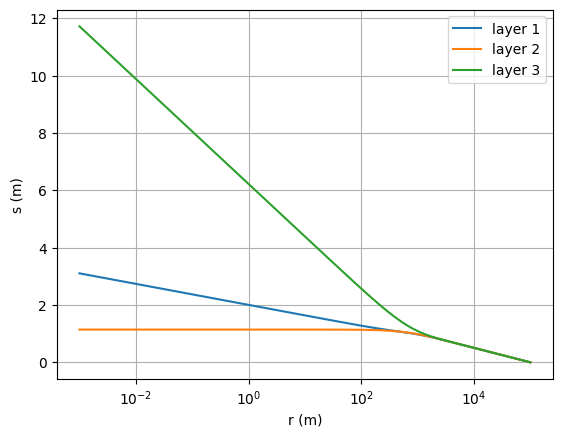

In [ ]:
# instantiating an object
m = MultiLayerSteadyWellFlow(R=1e5,  # outer model boundary
                             T=[100, 500, 200],  # three-layer aquifer system
                             c=[np.inf, 1000, 2000, np.inf],  # confined system
                             Q=[100, 0, 1000])  # well extracts from upper and lower layer

# generating distances r
r = np.logspace(-3, 5, 100)

# calculating drawdown s at distances r
s = m.s(r)

# plotting the result
plt.semilogx(r, s.T);  # need to transpose to get nr x nl matrix
plt.grid();
plt.xlabel('r (m)');
plt.ylabel('s (m)');
plt.legend([f'layer {i+1}' for i in range(m.nl)]);

## Superposition of wells

Defining classes `Well` and `AquiferSystem` to calculate drawdown due to multiple wells in a multilayer aquifer system applying the superposition method.

In [ ]:
class Well:
    '''
    class to define a well in a multilayer aquifer
    '''
    
    def __init__(self, x, y, Q, aquifer):
        '''
        x and y are the coordinates [L] of the well
        Q are the pumping rates [L³/T] for each layer (Q > 0 means extracting water)
        aquifer is an AquiferSystem object
        '''
        self.x = float(x)
        self.y = float(y)
        self.Q = np.array(Q, dtype=float)  # shape (nl,)
        self.aquifer = aquifer

    def s(self, x, y):
        '''
        calculates drawdown s [L] caused by the well at nodes (x, y)
        x and y are the coordinates [L] of the nodes (array-like)
        x and y both have shape (nrow, ncol)
        returns drawdown array s of shape (nl, nrow, ncol)
        '''
        x, y = np.array(x), np.array(y)
        shape = (self.aquifer.nl, ) + x.shape  # shape of s is (nl, nrow, ncol)
        R = np.sqrt(np.square(self.x - self.aquifer.x0) + np.square(self.y - self.aquifer.y0))  # determine R
        m = MultiLayerSteadyWellFlow(R=R, T=self.aquifer.T, c=self.aquifer.c, Q=self.Q)  # create model
        r = np.sqrt(np.square(self.x - x) + np.square(self.y - y))  # determine distances r
        return np.reshape(m.s(r=r.reshape(-1, 1)), shape)  # return drawdown array s

In [ ]:
class AquiferSystem:
    '''
    class to define a multilayer aquifer system that is extracted by pumping wells
    '''
    
    def __init__(self, T, c):
        '''                
        T is vector with layer transmissivities [L²/T] (array-like)
        c is vector with resistances [T] (array-like)
        '''
        self.T = np.array(T, dtype=float)  # shape (nl,)
        self.c = np.array(c, dtype=float)  # shape (nl+1,)
        self.nl = len(self.T)  # number of layers nl
        self.x0, self.y0 = 1e5, 1e5  # constant-head point (x0, y0)
        self.wells = []  # list of wells extracting from the aquifer system

    def add_well(self, x, y, Q):
        '''
        adds a pumping well to the aquifer system
        x and y are the coordinates [L] of the well
        Q are the pumping rates [L³/T] for each layer (Q > 0 means extracting water)
        returns Well object
        '''
        well = Well(x=x, y=y, Q=Q, aquifer=self)  # create Well object
        self.wells.append(well)  # append Well object to list of wells
        return well

    def s(self, x, y):
        '''
        calculates drawdown s [L] due to all wells in the aquifer system
        at nodes (x, y) applying the superposition method
        x and y are the coordinates [L] of the nodes (array-like)
        x and y both have shape (nrow, ncol)
        returns drawdown array s of shape (nl, nrow, ncol)
        '''
        x, y = np.array(x), np.array(y)
        s = np.zeros((self.nl, ) + x.shape)  # initialize drawdown array s
        for well in self.wells:  # run through all wells
            s += well.s(x, y)  # add well drawdown to s
        return s

Illustrating how these classes are used to simulate the effect of a well near a constant-head boundary (e.g. a river) applying the method of images.

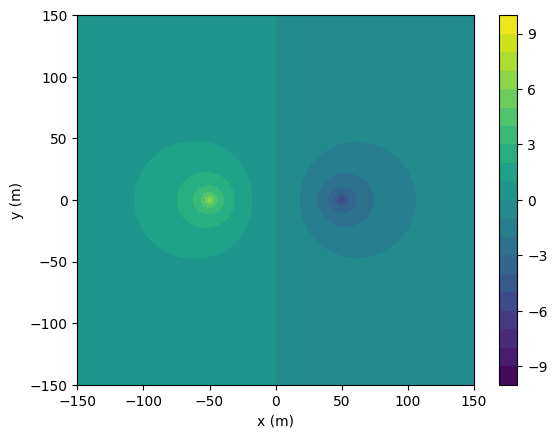

In [ ]:
# defining a leaky two-layer aquifer system
aquifer = AquiferSystem(T=[100, 50], 
                        c=[50, 100, np.inf])  # top is leaky

# defining a pumping well and its image well
pump = aquifer.add_well(x=-50, y=0, Q=1000)  # pumping well is located at 50 m from the river
image = aquifer.add_well(x=50, y=0, Q=-1000)  # image injection well

# generating the grid
coord = np.linspace(-150, 150, 100)
x, y = np.meshgrid(coord, coord)

# simulating drawdown at grid nodes
s = aquifer.s(x, y)

# plotting the result
plt.contourf(x, y, s[0, :, :], levels=np.arange(-10, 11));  # drawdown in top layer
plt.colorbar();
plt.xlabel('x (m)');
plt.ylabel('y (m)');

## The 'Duinenabdij' case

### The original pumping rate

The coordinates of the pumping and injection wells.

In [ ]:
# pumping wells
pwells = np.array([ [170.61611374, 246.2633452 ],
                    [197.63033175, 237.01067616],
                    [223.93364929, 236.29893238],
                    [248.81516588, 234.87544484],
                    [278.67298578, 237.72241993],
                    [287.91469194, 259.0747331 ],
                    [296.44549763, 286.12099644],
                    [320.61611374, 289.6797153 ],
                    [345.49763033, 294.66192171],
                    [375.35545024, 302.4911032 ],
                    [400.9478673 , 307.47330961],
                    [418.00947867, 276.8683274 ],
                    [398.81516588, 243.41637011],
                    [386.72985782, 217.08185053],
                    [370.37914692, 186.47686833],
                    [351.18483412, 170.81850534],
                    [326.30331754, 155.87188612],
                    [293.60189573, 168.68327402],
                    [270.85308057, 191.45907473],
                    [248.81516588, 187.90035587],
                    [222.51184834, 181.49466192],
                    [199.0521327 , 183.62989324],
                    [181.99052133, 200.        ],
                    [162.79620853, 217.79359431],
                    [409.47867299, 292.17081851],
                    [408.41232227, 260.14234875] ])

In [ ]:
# injection wells
iwells = np.array([ [106.63507109, 261.20996441],
                    [120.14218009, 272.59786477],
                    [138.62559242, 292.52669039],
                    [145.73459716, 306.76156584],
                    [161.37440758, 318.86120996],
                    [179.85781991, 326.69039146],
                    [193.36492891, 338.79003559],
                    [212.55924171, 346.61921708],
                    [231.04265403, 355.87188612],
                    [248.1042654 , 362.27758007],
                    [260.18957346, 368.68327402],
                    [272.98578199, 381.49466192],
                    [290.04739336, 388.61209964],
                    [310.66350711, 397.86476868],
                    [330.56872038, 412.8113879 ],
                    [352.60663507, 427.75800712],
                    [375.35545024, 425.6227758 ],
                    [393.12796209, 417.08185053],
                    [411.61137441, 417.08185053],
                    [429.38388626, 423.48754448],
                    [450.        , 423.48754448],
                    [477.72511848, 417.08185053],
                    [491.23222749, 397.86476868],
                    [463.86255924, 420.28469751] ])

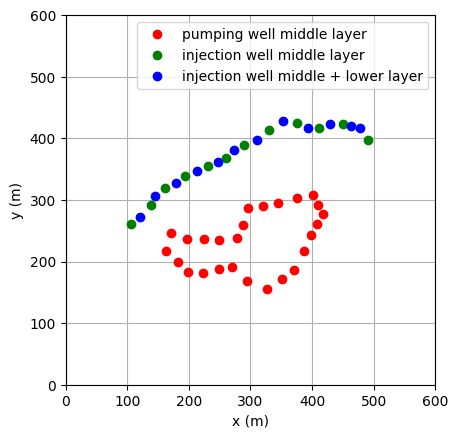

In [ ]:
# plotting the wells
plt.plot(pwells[:, 0], pwells[:, 1], 'ro', label='pumping well middle layer');
plt.plot(iwells[::2, 0], iwells[::2, 1], 'go', label='injection well middle layer');
plt.plot(iwells[1::2, 0], iwells[1::2, 1], 'bo', label='injection well middle + lower layer');

plt.xlabel('x (m)');
plt.ylabel('y (m)');
lim = (0, 600)
plt.xlim(lim);
plt.ylim(lim);
plt.grid();
plt.gca().set_aspect('equal', 'box');
plt.legend();

Adopting the original pumping and injection rates (m³/d) from Louwyck et al. (2005).

In [ ]:
# pumping and injection rates
npw, niw = len(pwells), len(iwells)
print(f"{npw} pumping wells")
print(f"{niw} injection wells")
Q_grav = 4.0  # P1: discharge through gravel pack surrounding the pumping wells (upper layer)
Q_pump = 60.0  # P2: pumping rate (middle layer)
Q_deep = -40.0  # P4: deep injection rate (lower layer)
Q_inj = -(npw * (Q_pump + Q_grav) + niw / 2 * Q_deep) / niw  # P3: injection rate (middle layer)
print(f"gravel pack discharge (upper layer): {Q_grav:.2f} m³/d")
print(f"pumping rate (middle layer): {Q_pump:.2f} m³/d")
print(f"injection rate (middle layer): {Q_inj:.2f} m³/d")
print(f"injection rate (lower layer): {Q_deep:.2f} m³/d")

26 pumping wells
24 injection wells
gravel pack discharge (upper layer): 4.00 m³/d
pumping rate (middle layer): 60.00 m³/d
injection rate (middle layer): -49.33 m³/d
injection rate (lower layer): -40.00 m³/d


Initializing the superposition model using class `AquiferSystem` and setting pumping rates to unit.

In [ ]:
# transmissivities T (m²/d) and resistances c (d)
T = [2.9 * 12, 5.2 * 13.8, 10.7 * 42.0]  # T = D * Kh
c = [np.inf, 1300.0, 49.70, np.inf]  # confined system

# instantiating an AquiferSystem object for each type of pumping or injection
pump = AquiferSystem(T=T, c=c)  # pumping middle layer
gravel = AquiferSystem(T=T, c=c)  # discharge via gravel pack upper layer
inject = AquiferSystem(T=T, c=c)  # injection middle layer
deep = AquiferSystem(T=T, c=c)  # deep infiltration lower layer

# adding pumping wells with unit discharge
for well in pwells:  
    x, y = tuple(well)
    gravel.add_well(x=x, y=y, 
                    Q=[1.0, 0.0, 0.0])  # U1
    pump.add_well(x=x, y=y, 
                  Q=[0.0, 1.0, 0.0])  # U2

# adding injection wells with unit discharge
for i, well in enumerate(iwells):
    x, y = tuple(well)
    inject.add_well(x=x, y=y, 
                    Q=[0.0, 1.0, 0.0])  # U2
    if i % 2:  # only half of the injection wells recharge the lower layer
        deep.add_well(x=x, y=y, 
                      Q=[0.0, 0.0, 1.0])  # U3

Simulating drawdown applying the superposition method for a 600m x 600m grid.

In [ ]:
# creating the grid
coord = np.linspace(0, 600, 100)
xgrid, ygrid = np.meshgrid(coord, coord)

# simulating drawdown using unit discharge/recharge
s_grav = gravel.s(xgrid, ygrid)
s_pump = pump.s(xgrid, ygrid)
s_inj = inject.s(xgrid, ygrid)
s_deep = deep.s(xgrid, ygrid)

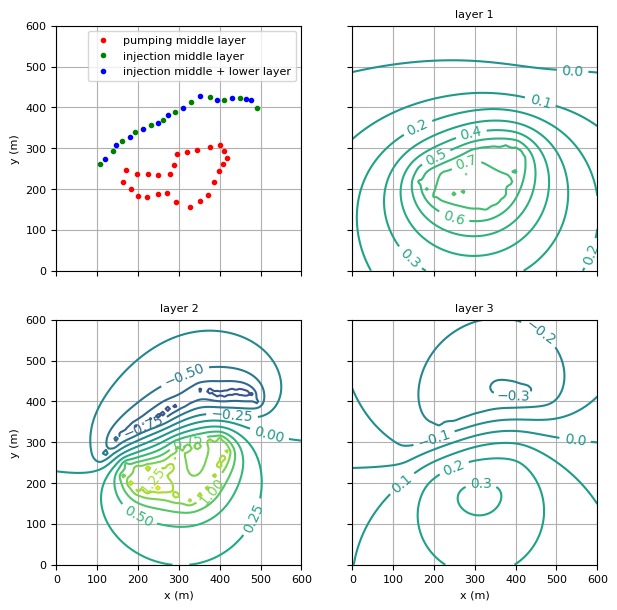

In [ ]:
# simulating drawdown according to Louwyck et al. (2005)
s = Q_grav * s_grav + Q_pump * s_pump + Q_inj * s_inj + Q_deep * s_deep  # s = P1*s1 + P2*s2 + P3*s3 + P4*s4

# plotting
fig, ax = plt.subplots(2, 2, figsize=(7, 7), sharex=True, sharey=True);

lim = (0, 600)
d = 100
fontsize = 8

ax[0][0].plot(pwells[:, 0], pwells[:, 1], 'r.', label='pumping middle layer');
ax[0][0].plot(iwells[::2, 0], iwells[::2, 1], 'g.', label='injection middle layer');
ax[0][0].plot(iwells[1::2, 0], iwells[1::2, 1], 'b.', label='injection middle + lower layer');
ax[0][0].set_xlim(lim);
ax[0][0].set_ylim(lim);
ax[0][0].set_aspect('equal', 'box');
ax[0][0].grid();

for i, a in enumerate([ax[0][1], ax[1][0], ax[1][1]]):
    step = 0.25 if i == 1 else 0.1
    cs = a.contour(xgrid, ygrid, s[i, :, :], levels=np.arange(-2, 2, step))
    a.clabel(cs, cs.levels, inline=True);
    a.set_title('layer ' + str(i+1), fontsize=fontsize);
    a.set_xlim(lim);
    a.set_ylim(lim);
    a.set_aspect('equal', 'box');
    a.grid()

ax[0][0].set_yticks(np.arange(lim[0], lim[1] + d, d));
ax[0][0].set_yticklabels(np.arange(lim[0], lim[1] + d, d), fontsize=fontsize);
ax[1][0].set_yticks(np.arange(lim[0], lim[1] + d, d));
ax[1][0].set_yticklabels(np.arange(lim[0], lim[1] + d, d), fontsize=fontsize);
ax[1][0].set_xticks(np.arange(lim[0], lim[1] + d, d));
ax[1][0].set_xticklabels(np.arange(lim[0], lim[1] + d, d), fontsize=fontsize);
ax[1][1].set_xticks(np.arange(lim[0], lim[1] + d, d));
ax[1][1].set_xticklabels(np.arange(lim[0], lim[1] + d, d), fontsize=fontsize);
ax[0][0].set_ylabel('y (m)', fontsize=fontsize);
ax[1][0].set_ylabel('y (m)', fontsize=fontsize);
ax[1][0].set_xlabel('x (m)', fontsize=fontsize);
ax[1][1].set_xlabel('x (m)', fontsize=fontsize);
ax[0][0].legend(fontsize=fontsize);

Drawdown in the top layer at the excavation site (surrounded by red dots) is close to yet less than 1 m.

### Optimizing the pumping rate using PuLP

Defining the control points at which drawdown must be at least 1 m.

In [ ]:
# control points
xc = [300, 300, 350, 350]
yc = [200, 250, 200, 250]

# drawdown in these points (top layer only)
s1 = gravel.s(xc, yc)[0, :]
s2 = pump.s(xc, yc)[0, :]
s3 = inject.s(xc, yc)[0, :]
s4 = deep.s(xc, yc)[0, :]

**Scenario 1: injection rate lower layer is constant**

In [ ]:
# instantiating LpProblem object (linear programming problem)
prob = LpProblem("Scenario_1", LpMinimize)  # it's a minimization problem

# defining the variables
Q_pump1 = LpVariable("Q_pump", lowBound=0)  # pumping rate middle layer (Q > 0)
Q_inj1 = LpVariable("Q_inj", upBound=0)  # injection rate middle layer (Q < 0)

# defining the objective function
prob += Q_pump1, "minimize total pumping rate"

# adding constraint Q_out == Q_in
prob += npw * (Q_grav + Q_pump1) + niw * Q_inj1 + niw / 2 * Q_deep == 0

# add constraint at the 4 control points
for i in range(len(xc)):
    # drawdown in top layer must be at least 1 m: P1*s1 + P2*s2 + P3*s3 + P4*s4 >= 1
    prob += Q_grav * s1[i] + Q_pump1 * s2[i] + Q_inj1 * s3[i] + Q_deep * s4[i] >= 1.0

# solving the problem
print(prob.solve())
print(LpStatus[prob.status])  # checking the status of the solution
print(Q_pump1.value(), Q_inj1.value(), Q_deep)  # checking the optimized variables

1
Optimal
182.73261 -182.29366 -40.0


In [ ]:
# checking the constraints
print(Q_grav * s1 + Q_pump1.value() * s2 + Q_inj1.value() * s3 + Q_deep * s4)
print(npw * (Q_grav + Q_pump1.value()) + niw * Q_inj1.value() + niw / 2 * Q_deep)

[1.1545491  1.02922671 1.115928   1.00000003]
2.0000000404252205e-05


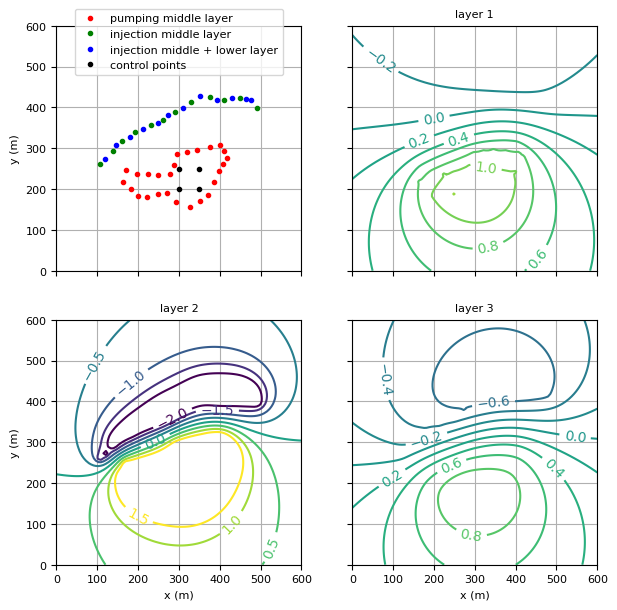

In [ ]:
# simulating drawdown: P1*s1 + P2*s2 + P3*s3 + P4*s4
s = Q_grav * s_grav + Q_pump1.value() * s_pump + Q_inj1.value() * s_inj + Q_deep * s_deep

# plotting
fig, ax = plt.subplots(2, 2, figsize=(7, 7), sharex=True, sharey=True);

lim = (0, 600)
d = 100
fontsize = 8

ax[0][0].plot(pwells[:, 0], pwells[:, 1], 'r.', label='pumping middle layer');
ax[0][0].plot(iwells[::2, 0], iwells[::2, 1], 'g.', label='injection middle layer');
ax[0][0].plot(iwells[1::2, 0], iwells[1::2, 1], 'b.', label='injection middle + lower layer');
ax[0][0].plot(xc, yc, 'k.', label='control points')
ax[0][0].set_xlim(lim);
ax[0][0].set_ylim(lim);
ax[0][0].set_aspect('equal', 'box');
ax[0][0].grid();

for i, a in enumerate([ax[0][1], ax[1][0], ax[1][1]]):
    step = 0.5 if i == 1 else 0.2
    cs = a.contour(xgrid, ygrid, s[i, :, :], levels=np.arange(-2, 2, step))
    a.clabel(cs, cs.levels, inline=True);
    a.set_title('layer ' + str(i+1), fontsize=fontsize);
    a.set_xlim(lim);
    a.set_ylim(lim);
    a.set_aspect('equal', 'box');
    a.grid()

ax[0][0].set_yticks(np.arange(lim[0], lim[1] + d, d));
ax[0][0].set_yticklabels(np.arange(lim[0], lim[1] + d, d), fontsize=fontsize);
ax[1][0].set_yticks(np.arange(lim[0], lim[1] + d, d));
ax[1][0].set_yticklabels(np.arange(lim[0], lim[1] + d, d), fontsize=fontsize);
ax[1][0].set_xticks(np.arange(lim[0], lim[1] + d, d));
ax[1][0].set_xticklabels(np.arange(lim[0], lim[1] + d, d), fontsize=fontsize);
ax[1][1].set_xticks(np.arange(lim[0], lim[1] + d, d));
ax[1][1].set_xticklabels(np.arange(lim[0], lim[1] + d, d), fontsize=fontsize);
ax[0][0].set_ylabel('y (m)', fontsize=fontsize);
ax[1][0].set_ylabel('y (m)', fontsize=fontsize);
ax[1][0].set_xlabel('x (m)', fontsize=fontsize);
ax[1][1].set_xlabel('x (m)', fontsize=fontsize);
ax[0][0].legend(fontsize=fontsize, loc=(0.075, 0.8));

Drawdown in the top layer at the excavation site (surrounded by red dots) is at least 1 m.

**Scenario 2: injection rate lower layer is variable**

In [ ]:
# instantiating LpProblem object (linear programming problem)
prob = LpProblem("Scenario_2", LpMinimize)  # it's a minimization problem

# defining the variables
Q_pump2 = LpVariable("Q_pump", lowBound=0)  # pumping rate middle layer (Q > 0)
Q_inj2 = LpVariable("Q_inj", upBound=0)  # injection rate middle layer (Q < 0)
Q_deep2 = LpVariable("Q_deep", upBound=0)  # injection rate lower layer (Q < 0)

# defining the objective function
prob += Q_pump2, "minimize total pumping rate"

# adding constraint Q_out == Q_in
prob += npw * (Q_grav + Q_pump2) + niw * Q_inj2 + niw / 2 * Q_deep2 == 0

# add constraint at the 4 control points
for i in range(len(xc)):
    # drawdown in top layer must be at least 1 m: P1*s1 + P2*s2 + P3*s3 + P4*s4 >= 1
    prob += Q_grav * s1[i] + Q_pump2 * s2[i] + Q_inj2 * s3[i] + Q_deep2 * s4[i] >= 1.0

# solving the problem
print(prob.solve())
print(LpStatus[prob.status])  # checking the status of the solution
print(Q_pump2.value(), Q_inj2.value(), Q_deep2.value())  # checking the optimized variables

1
Optimal
107.96426 0.0 -242.58923


In [ ]:
# checking the constraints
print(Q_grav * s1 + Q_pump2.value() * s2 + Q_inj2.value() * s3 + Q_deep2.value() * s4)
print(npw * (Q_grav + Q_pump2.value()) + niw * Q_inj2.value() + niw / 2 * Q_deep2.value())

[1.07350538 1.05369702 1.02303665 1.00000001]
4.547473508864641e-13


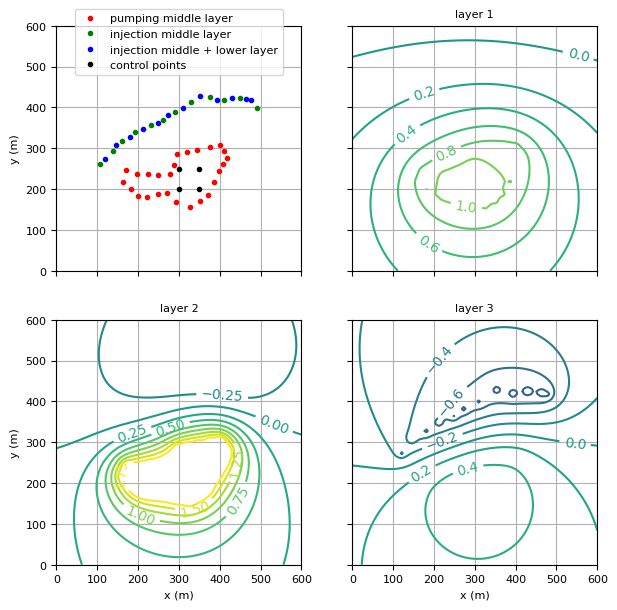

In [ ]:
# simulating drawdown: P1*s1 + P2*s2 + P3*s3 + P4*s4
s = Q_grav * s_grav + Q_pump2.value() * s_pump + Q_inj2.value() * s_inj + Q_deep2.value() * s_deep

# plotting
fig, ax = plt.subplots(2, 2, figsize=(7, 7), sharex=True, sharey=True);

lim = (0, 600)
d = 100
fontsize = 8

ax[0][0].plot(pwells[:, 0], pwells[:, 1], 'r.', label='pumping middle layer');
ax[0][0].plot(iwells[::2, 0], iwells[::2, 1], 'g.', label='injection middle layer');
ax[0][0].plot(iwells[1::2, 0], iwells[1::2, 1], 'b.', label='injection middle + lower layer');
ax[0][0].plot(xc, yc, 'k.', label='control points')
ax[0][0].set_xlim(lim);
ax[0][0].set_ylim(lim);
ax[0][0].set_aspect('equal', 'box');
ax[0][0].grid();

for i, a in enumerate([ax[0][1], ax[1][0], ax[1][1]]):
    step = 0.25 if i == 1 else 0.2
    cs = a.contour(xgrid, ygrid, s[i, :, :], levels=np.arange(-2, 2, step))
    a.clabel(cs, cs.levels, inline=True);
    a.set_title('layer ' + str(i+1), fontsize=fontsize);
    a.set_xlim(lim);
    a.set_ylim(lim);
    a.set_aspect('equal', 'box');
    a.grid()

ax[0][0].set_yticks(np.arange(lim[0], lim[1] + d, d));
ax[0][0].set_yticklabels(np.arange(lim[0], lim[1] + d, d), fontsize=fontsize);
ax[1][0].set_yticks(np.arange(lim[0], lim[1] + d, d));
ax[1][0].set_yticklabels(np.arange(lim[0], lim[1] + d, d), fontsize=fontsize);
ax[1][0].set_xticks(np.arange(lim[0], lim[1] + d, d));
ax[1][0].set_xticklabels(np.arange(lim[0], lim[1] + d, d), fontsize=fontsize);
ax[1][1].set_xticks(np.arange(lim[0], lim[1] + d, d));
ax[1][1].set_xticklabels(np.arange(lim[0], lim[1] + d, d), fontsize=fontsize);
ax[0][0].set_ylabel('y (m)', fontsize=fontsize);
ax[1][0].set_ylabel('y (m)', fontsize=fontsize);
ax[1][0].set_xlabel('x (m)', fontsize=fontsize);
ax[1][1].set_xlabel('x (m)', fontsize=fontsize);
ax[0][0].legend(fontsize=fontsize, loc=(0.075, 0.8));

Drawdown in the top layer at the excavation site (surrounded by red dots) is at least 1 m and the optimal pumping rate is significant smaller.

---